# Run single-station location for the West-Caspian-Fault paper

**Note**: this notebook assumes you have the loc1sta python files available in your PYTHONPATH. This could be as simple as having the loc1sta directory in the same directory as this notebook. You will also need a data directory and a figures directory.


In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from obspy import UTCDateTime, read_inventory
from obspy.clients.filesystem.sds import Client as SDS_Client
from loc1sta.epicentral_distance import load_sp_time_differences_and_angles, get_distances_and_angles_as_function_of_depth_from_model_data, get_location_from_sta_dist_km_azimuth
from loc1sta.catalogs import read_snuffler_phase_times
from loc1sta.waveforms import extract_waveforms_given_picks
from loc1sta.polarization_analysis import compute_azimuthal_parameters_for_stream_list, compute_azimuthal_parameters_flinn_for_stream_list, compute_azimuthal_parameters_pm_for_stream_list
from loc1sta.graphics import plot_table_of_streams

In [46]:
DATA_DIR = 'data'
FIG_DIR = 'figures'

DOWNLOAD_DATA = False
RECALC_MODEL = False
DO_PLOTS = False

PRECISION = 3

In [47]:
# constants for the data
START_TIME = UTCDateTime('2023-02-03T00:00:00.0Z')
END_TIME = UTCDateTime('2023-02-10T00:00:00.0Z')
YEAR = 2023
STATION = 'HASN'
# STATION = 'KHDR'
NETWORK = 'AB'
LOCATION = '00'
CHANNEL = 'HH?'

inventory_filename = os.path.join(DATA_DIR, f'{NETWORK}.{STATION}.xml')
SDS_directory = os.path.join(DATA_DIR, 'SDS')

# constants for cutting the data
CUT_LEFT = 2.0 # large cut, seconds before P
CUT_RIGHT = 5.0 # large cut, seconds after P
CUT_LEFT_P = 0.05 # close cut, seconds before P
CUT_RIGHT_P = 0.2 # close cut, seconds after P
DEF_BUFFER_P = 1.0 # a buffer, in seconds, to use when using close cut

# filter
DEF_MIN_FREQ = 5.0  # high-pass filter value

# pick filenames
#snuffler_pick_filenames = ['highHZ_HASN.txt', 'HASN_tribe2.txt', 'HASN_all.txt']
snuffler_pick_filenames = ['HASN_all.txt']
# snuffler_pick_filenames = ['HASN_trib2_0602_0902.txt']
# snuffler_pick_filenames = ['HASN_all_latest.txt']
# snuffler_pick_filenames = ['KHDR_06022023.txt']

# constants for estimating uncertainties
N_SAMPLES = 1000

# Quality control
MIN_SNR = 0.0
MIN_COHERENCE = -5.0

## Get the data

In [48]:
# Download the raw data if necessary
if DOWNLOAD_DATA:
    from obspy.clients.fdsn import Client as FDSN_Client
    from loc1sta.waveforms import setup_sds_system

    fdsn_client = FDSN_Client('IRIS')

    # get the station metadata
    print('Getting stations')
    inv = fdsn_client.get_stations(network=NETWORK, station=STATION, starttime=START_TIME, endtime=END_TIME, level='response')
    inv.write(inventory_filename, format='STATIONXML')
    print('Got stations')

    # get the waveform data and write it to an SDS system
    print('Getting waveforms')
    START_TIME = UTCDateTime('2023-02-05T00:00:00.0Z')
    END_TIME = UTCDateTime('2023-02-06T00:00:00.0Z')
    st = fdsn_client.get_waveforms(NETWORK, STATION, LOCATION, CHANNEL, START_TIME, END_TIME)
    print('Got waveforms')
    setup_sds_system(SDS_directory, st, YEAR, START_TIME, END_TIME)
    print('Archived waveforms')


In [49]:
# from obspy import read
# from loc1sta.waveforms import setup_sds_system

# st.write('data/tmp_seed_file', format='MSEED')
# st = read('data/tmp_seed_file')
# setup_sds_system(SDS_directory, st, YEAR, START_TIME, END_TIME)



In [50]:
# set up the tools for accessing the data
sds_client = SDS_Client('data/SDS')

## Prepare the velocity model

In [51]:
# Create and write the local model and plot a comparison with a standard model
if RECALC_MODEL:
    import obspy.taup as taup
    from obspy.taup.taup_create import build_taup_model
    from loc1sta.epicentral_distance import get_sp_time_differences_and_angles

    MIN_DEG = 0.0
    MAX_DEG = 0.5

    m_iasp = taup.TauPyModel("iasp91")
    m_ak135 = taup.TauPyModel("ak135")

    build_taup_model(filename=os.path.join(DATA_DIR, "lower_kura_model.tvel"))
    m_lower_kura = taup.TauPyModel("lower_kura_model")

    # plot comparison with a standard model
    if DO_PLOTS:
        source_depth_km = 13.0
        dist_deg, sp_times_ak135, angles_ak135, takeoff_ak135 = get_sp_time_differences_and_angles(m_ak135, MIN_DEG, MAX_DEG, source_depth_km)
        dist_deg, sp_times_lower_kura, angles_lower_kura, takeoff_lower_kura = get_sp_time_differences_and_angles(m_lower_kura, MIN_DEG, MAX_DEG, source_depth_km)
        dist_km = dist_deg * 111.25

        figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

        # S-P time as a function of distance
        ax = axes[0]
        plt.sca(ax)
        plt.plot(dist_km, sp_times_ak135, label="ak135")
        plt.plot(dist_km, sp_times_lower_kura, label='Lower Kura')
        plt.xlim(0, 20)
        plt.ylim(0, 6)
        plt.ylabel('S-P time (seconds)')
        plt.xlabel('Epicentral distance (km)')
        plt.legend(loc='upper left')
        plt.text(.95, .95, 'a', weight='bold', ha='right', va='top', transform=ax.transAxes)

        # incidence angle at the station as a function of distance
        ax = axes[1]
        plt.sca(ax)
        plt.plot(dist_km, angles_ak135, label="ak135")
        plt.plot(dist_km, angles_lower_kura, label='Lower Kura')
        plt.xlim(0, 20)
        plt.ylim(0, 70)
        plt.ylabel('Incidence angle (degrees)')
        plt.xlabel('Epicentral distance (km)')
        plt.legend(loc='upper left')
        plt.text(.95, .95, 'b', weight='bold', ha='right', va='top', transform=ax.transAxes)

        # Take-off angle as a function of distance
        # Note that for this paper, the take-off angles are upper-hemisphere take-off angles as
        # most of the rays that reach the station take off upwards ; if this is no longer the case,
        # plot the takeoff angles directly instead of 180-takeoff angles.
        ax = axes[2]
        plt.sca(ax)
        plt.plot(dist_km, 180-takeoff_ak135, label="ak135")
        plt.plot(dist_km, 180-takeoff_lower_kura, label='Lower Kura')
        plt.xlim(0, 20)
        plt.ylim(0, 90)
        plt.ylabel('Take-off angle (degrees)')
        plt.xlabel('Epicentral distance (km)')
        plt.legend(loc='upper left')
        plt.text(.95, .95, 'c', weight='bold', ha='right', va='top', transform=ax.transAxes)

        plt.savefig('figures/compare_sp_times_for_all_models_depth_13.png')

In [52]:
# Iterate over each depth to generate files containing S-P times, incidence angles, epicentral distances, and takeoff angles for each depth.

if RECALC_MODEL:
    from loc1sta.epicentral_distance import get_sp_time_differences_and_angles, save_sp_time_differences_and_angles

    MIN_DEPTH = 0
    MAX_DEPTH = 20
    N_DEPTH = 2 * (MAX_DEPTH - MIN_DEPTH) + 1
    source_depths = np.linspace(MIN_DEPTH, MAX_DEPTH, N_DEPTH)

    for source_depth_km in source_depths:
        dist_deg, sp_times_lower_kura, p_angles, t_angles = get_sp_time_differences_and_angles(m_lower_kura, MIN_DEG, MAX_DEG, source_depth_km)
        save_sp_time_differences_and_angles(distances_deg=dist_deg, sp_times=sp_times_lower_kura,
                                            incident_angles=p_angles, takeoff_angles=t_angles,
                                            source_depth=source_depth_km, dirname=DATA_DIR, basename='lower_kura')

## Get the arrival times of events

In [53]:
# assume the pick files have the same number of P and S picks, so they can be simply interpreted
# read the pick files, extract the P-arrivals and the S-P times
data_df_dict = {}
for pick_filename in snuffler_pick_filenames:
    pick_name = pick_filename.split('.')[0]
    df = read_snuffler_phase_times(os.path.join(DATA_DIR, pick_filename))
    df.sort_values(by='UTC_Time', inplace=True)
    df_P = df.loc[df['Phase']=='P'].copy()
    df_S = df.loc[df['Phase']=='S']
    UTC_P_picks = [UTCDateTime(pick) for pick in df_P['UTC_Time'].values]
    UTC_S_picks = [UTCDateTime(pick) for pick in df_S['UTC_Time'].values]
    n_events, bid = df_P.shape
    SP_times = [UTC_S_picks[i] - UTC_P_picks[i] for i in range(n_events)]
    df_P['SP_Time'] = SP_times
    data_df_dict[pick_name] = df_P
    df_P.round(PRECISION).to_csv(os.path.join(DATA_DIR, f'{pick_name}_SP.csv'), index=False, sep=' ')

## Select the events with adequate signal-to-noise ratio and compute P-wave coherence, incidence angle and azimuth

In [54]:
for pick_name, df in data_df_dict.items():
    p_picks = df['UTC_Time'].values

    # extract the waveforms for events with P-wave SNR > MIN_SNR
    good_streams, good_data_flags = extract_waveforms_given_picks(p_picks, sds_client, network=NETWORK, min_freq=DEF_MIN_FREQ,
                                                                  station=STATION, channel=CHANNEL,
                                                                  location=LOCATION, min_snr=MIN_SNR,
                                                                  cut_left=CUT_LEFT, cut_right=CUT_RIGHT)
    df['Good_SNR'] = good_data_flags
    df_good = df.loc[df['Good_SNR']==1].copy()

    if DO_PLOTS:
        SP_times = df_good['SP_Time'].values
        fig_filename = f'{pick_name}_good_SNR_waveforms.png'
        plot_table_of_streams(good_streams, CUT_LEFT, os.path.join(FIG_DIR, fig_filename),
                              xticks=[-1, 0, 1, 2, 3], sp_times=SP_times)

    # extract just the P-wave waveforms for events with P-wave SNR > MIN_SNR
    good_P_streams, good_data_flags = extract_waveforms_given_picks(p_picks, sds_client, network=NETWORK,
                                                                    min_freq=DEF_MIN_FREQ,station=STATION, channel=CHANNEL, location=LOCATION, min_snr=MIN_SNR, cut_left=CUT_LEFT_P,
                                                                    cut_right=CUT_RIGHT_P)

    if DO_PLOTS:
        fig_filename = f'{pick_name}_good_SNR_P_waveforms.png'
        plot_table_of_streams(good_P_streams, CUT_LEFT_P, os.path.join(FIG_DIR, fig_filename),
                              xticks=[0, 0.1, 0.2])

    # find incidence, azimuth, and P-wave coherence for the good P-wave streams
    df_good['i_angle'], df_good['i_unc'], df_good['azimuth'], df_good['az_unc'], df_good['coherence'] =\
        compute_azimuthal_parameters_for_stream_list(good_P_streams)
    df_good['flinn_azimuth'], df_good['flinn_i_angle'], df_good['flinn_rect'], df_good['flinn_plan'] = compute_azimuthal_parameters_flinn_for_stream_list(good_P_streams)
    df_good['pm_azimuth'], df_good['pm_i_angle'], df_good['pm_az_unc'], df_good['pm_i_unc'] = compute_azimuthal_parameters_pm_for_stream_list(good_P_streams)

    # save this to file so it can be read later
    csv_filename = f'{pick_name}_good_SNR_param.csv'
    df_good.round(PRECISION).to_csv(os.path.join(DATA_DIR, csv_filename), index=False, sep=' ')

## Complete the location

To do this we take the measurements in the good_SNR_param files and use the measured incidence angles and S-P times to infer distance and depth from the model files.

In [55]:
# read all the depth-dependent files and create a dictionary from them
model_df_dict = load_sp_time_differences_and_angles(dirname=DATA_DIR, basename='lower_kura')

# read the station position
inv = read_inventory(inventory_filename)
coords = inv.get_coordinates(seed_id=f'{NETWORK}.{STATION}.{LOCATION}.HHZ')
sta_lat = coords['latitude']
sta_lon = coords['longitude']

# read the good_SNR_param files
for pick_name in data_df_dict.keys():
    csv_filename = f'{pick_name}_good_SNR_param.csv'
    df = pd.read_csv(os.path.join(DATA_DIR, csv_filename), sep=' ')

    # add columns to the dataframe
    df = df.reindex(columns = df.columns.tolist() + ['depth_km', 'depth_unc', 'dist_km', 'dist_unc', 't_angle', 't_angle_unc', 'ev_lat', 'ev_lat_unc', 'ev_lon', 'ev_lon_unc'])

    # iterate over the rows of the dataframe
    n_rows, n_cols = df.shape
    for i in range(n_rows):
        sp_time = df.loc[i, 'SP_Time']
        i_angle = df.loc[i, 'i_angle']
        i_unc = df.loc[i, 'i_unc']

        # extract model predictions for the appropriate SP time
        depths, dist_km, angles, t_angles = get_distances_and_angles_as_function_of_depth_from_model_data(model_df_dict, sp_time)

        # sort angles in ascending order to permit interpolation
        idx = np.argsort(angles)
        angles_sorted = np.array(angles)[idx]
        depths_sorted = np.array(depths)[idx]
        dist_km_sorted = np.array(dist_km)[idx]
        t_angles_sorted = np.array(t_angles)[idx]

        # interpolate the predictions for the measured incidence angle
        # use the central value to get the central value
        df.loc[i, 'depth_km'] = np.interp(i_angle, angles_sorted, depths_sorted)
        df.loc[i, 'dist_km'] = np.interp(i_angle, angles_sorted, dist_km_sorted)
        df.loc[i, 't_angle'] = np.interp(i_angle, angles_sorted, t_angles_sorted)

        # translate azimuth and distance into position
        df.loc[i, 'ev_lat'], df.loc[i, 'ev_lon'] = get_location_from_sta_dist_km_azimuth(sta_lat=sta_lat, sta_lon=sta_lon, dist_km=df.loc[i, 'dist_km'], azimuth=df.loc[i, 'azimuth'])


        # use the uncertainty on the incidence angle to get the uncertainties in the predictions
        i_samples = norm(i_angle, i_unc).rvs(N_SAMPLES)
        my_depths = np.interp(i_samples, angles_sorted, depths_sorted)
        my_dists = np.interp(i_samples, angles_sorted, dist_km_sorted)
        my_t_angles = np.interp(i_samples, angles_sorted, t_angles_sorted)
        my_azimuths = norm(df.loc[i, 'azimuth'], df.loc[i, 'az_unc']).rvs(N_SAMPLES)
        my_ev_lat, my_ev_lon = get_location_from_sta_dist_km_azimuth(sta_lat=sta_lat, sta_lon=sta_lon,
                                                                     dist_km=my_dists, azimuth=my_azimuths)
        df.loc[i, 'depth_unc'] = np.std(my_depths)
        df.loc[i, 'dist_unc'] = np.std(my_dists)
        df.loc[i, 't_angle_unc'] = np.std(my_t_angles)
        df.loc[i, 'ev_lat_unc'] = np.std(my_ev_lat)
        df.loc[i, 'ev_lon_unc'] = np.std(my_ev_lon)

    # save this to file so it can be read later
    csv_filename = f'{pick_name}_good_SNR_location.csv'
    df.round(PRECISION).to_csv(os.path.join(DATA_DIR, csv_filename), index=False, sep=' ')


In [56]:
# filter using coherence > MIN_COHERENCE & rectilinarity > 0.8
# read the good_SNR_param files
for pick_name in data_df_dict.keys():
    csv_filename = f'{pick_name}_good_SNR_location.csv'
    df = pd.read_csv(os.path.join(DATA_DIR, csv_filename), sep=' ')

    filtered_df = df.loc[(df['coherence']>MIN_COHERENCE) & (df['flinn_rect'] > 0.8)]
    csv_filename = f'{pick_name}_good_SNR_and_coherence_location.csv'
    filtered_df.round(PRECISION).to_csv(os.path.join(DATA_DIR, csv_filename), index=False, sep=' ')

In [57]:
# output latex files
for pick_name in data_df_dict.keys():
    csv_filename = f'{pick_name}_good_SNR_and_coherence_location.csv'
    df = pd.read_csv(os.path.join(DATA_DIR, csv_filename), sep=' ')
    latex_filename = os.path.join(DATA_DIR, f'{pick_name}_good_SNR_and_coherence_location.tex')

    # create columns that combine values and uncertainties
    n_rows, n_cols = df.shape
    for i in range(n_rows):
        value = df.loc[i, 'i_angle']
        sigma = df.loc[i, 'i_unc']
        df.loc[i, 'i_angle'] = f'{value:.0f} $\\pm$ {sigma:.0f}'
        value = df.loc[i, 'azimuth']
        sigma = df.loc[i, 'az_unc']
        df.loc[i, 'azimuth'] = f'{value:.0f} $\\pm$ {sigma:.0f}'
        value = df.loc[i, 'depth_km']
        sigma = df.loc[i, 'depth_unc']
        df.loc[i, 'depth_km'] = f'{value:.1f} $\\pm$ {sigma:.1f}'
        value = df.loc[i, 'dist_km']
        sigma = df.loc[i, 'dist_unc']
        df.loc[i, 'dist_km'] = f'{value:.1f} $\\pm$ {sigma:.1f}'
        value = df.loc[i, 'ev_lat']
        sigma = df.loc[i, 'ev_lat_unc']
        df.loc[i, 'ev_lat'] = f'{value:.3f} $\\pm$ {sigma:.3f}'
        value = df.loc[i, 'ev_lon']
        sigma = df.loc[i, 'ev_lon_unc']
        df.loc[i, 'ev_lon'] = f'{value:.3f} $\\pm$ {sigma:.3f}'
        value = df.loc[i, 't_angle']
        sigma = df.loc[i, 't_angle_unc']
        df.loc[i, 't_angle'] = f'{value:.0f} $\\pm$ {sigma:.0f}'
    df_out = df[['UTC_Time', 'SP_Time', 'coherence', 'flinn_rect', 'i_angle', 'azimuth', 'depth_km',  'dist_km',
                 'ev_lat', 'ev_lon',  't_angle',]]
    df_out = df_out.rename(columns={'UTC_Time': '$P$ arrival', 'SP_Time': '$S$-$P$',
                                    'coherence': 'Coh.', 'flinn_rect': 'Rect.', 'i_angle': '$i$', 'azimuth': 'Az.',
                                    'depth_km': '$z$ (km)', 'dist_km': '$\\Delta$. (km)',
                                    'ev_lat': 'Lat N', 'ev_lon': 'Lon E', 't_angle': '$\\theta$'})
    s=df_out.style.format({'$S$-$P$': '{:.3f}', 'Coh.':'{:.1f}', 'Rect.':'{:.2f}'})
    s.hide(axis="index").to_latex(latex_filename, hrules=True, position_float='centering', label=f'tab:{pick_name}')

In [58]:
# function to plot depth, epicentral distance, and takeoff angle with respect to incidence angle for a given S-P time
def plot_depths_distances_angles(depths, dist_km, angles, t_angles, sp_time):
    plt.style.use('classic')
    figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    plt.sca(axes[0])
    ax = plt.gca()
    plt.plot(angles, depths, color='k')
    plt.xlabel('Incidence angle (degrees)')
    plt.ylabel('Source depth (km)')
    plt.xlim(0, 14)
    plt.ylim(10, 20)
    plt.text(.95, .95, 'a', weight='bold', ha='right', va='top', transform=ax.transAxes)

    plt.sca(axes[1])
    ax = plt.gca()
    plt.plot(angles, dist_km, color='k')
    plt.xlabel('Incidence angle (degrees)')
    plt.ylabel('Epicentral distance (km)')
    plt.xlim(0, 14)
    plt.ylim(0, 8)
    plt.text(.95, .95, 'b', weight='bold', ha='right', va='top', transform=ax.transAxes)

    plt.sca(axes[2])
    ax = plt.gca()
    plt.plot(angles, 90-(np.array(t_angles)-90), color='k')
    plt.xlabel('Incidence angle (degrees)')
    plt.ylabel('Takeoff angle (degrees)')
    plt.xlim(0, 14)
    plt.ylim(0, 45)
    plt.text(.95, .95, 'c', weight='bold', ha='right', va='top', transform=ax.transAxes)

    plt.suptitle(f'S-P time {sp_time:%1.2f}s')
    plt.savefig(os.path.join(FIG_DIR, f'depth_dist_takeoff_vs_incidence_for_sp_time_{sp_time:%1.2f}s.png'))


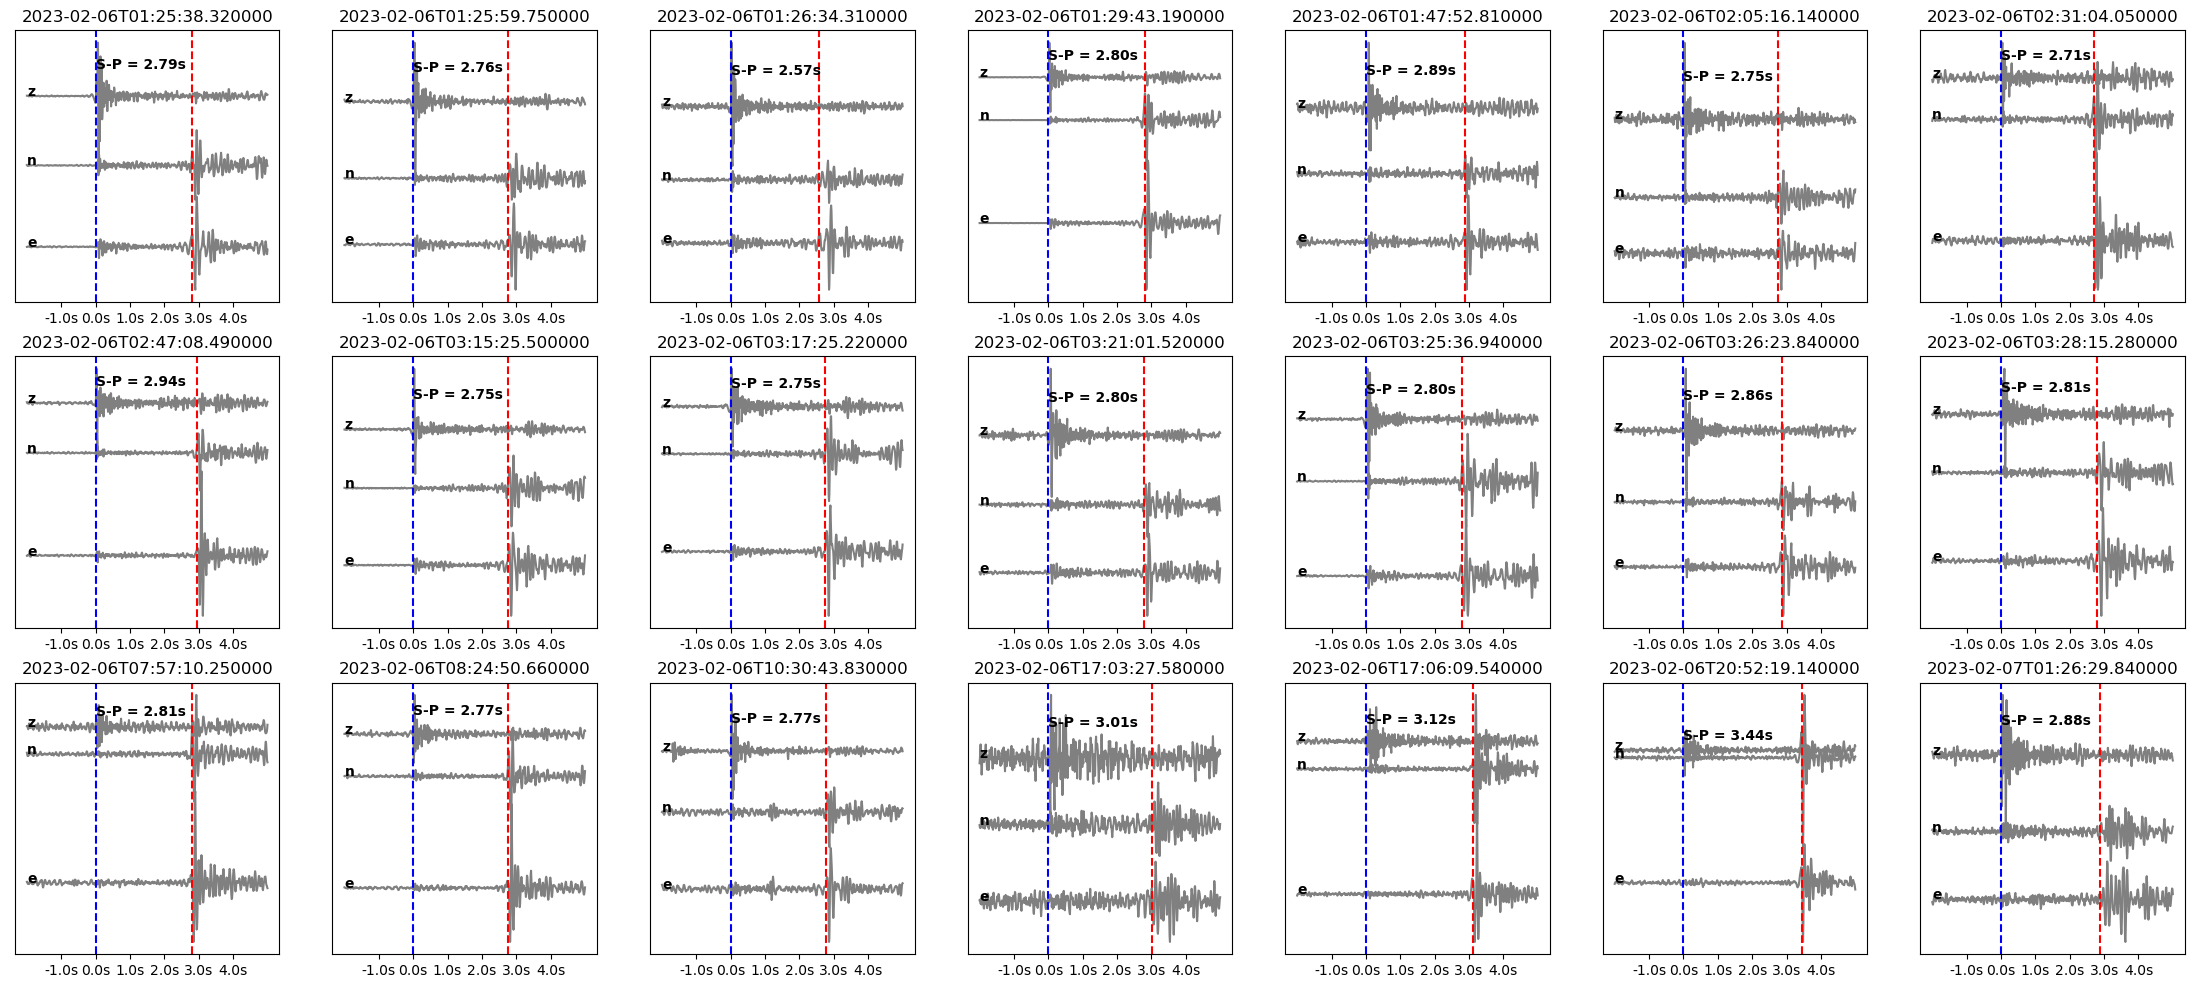

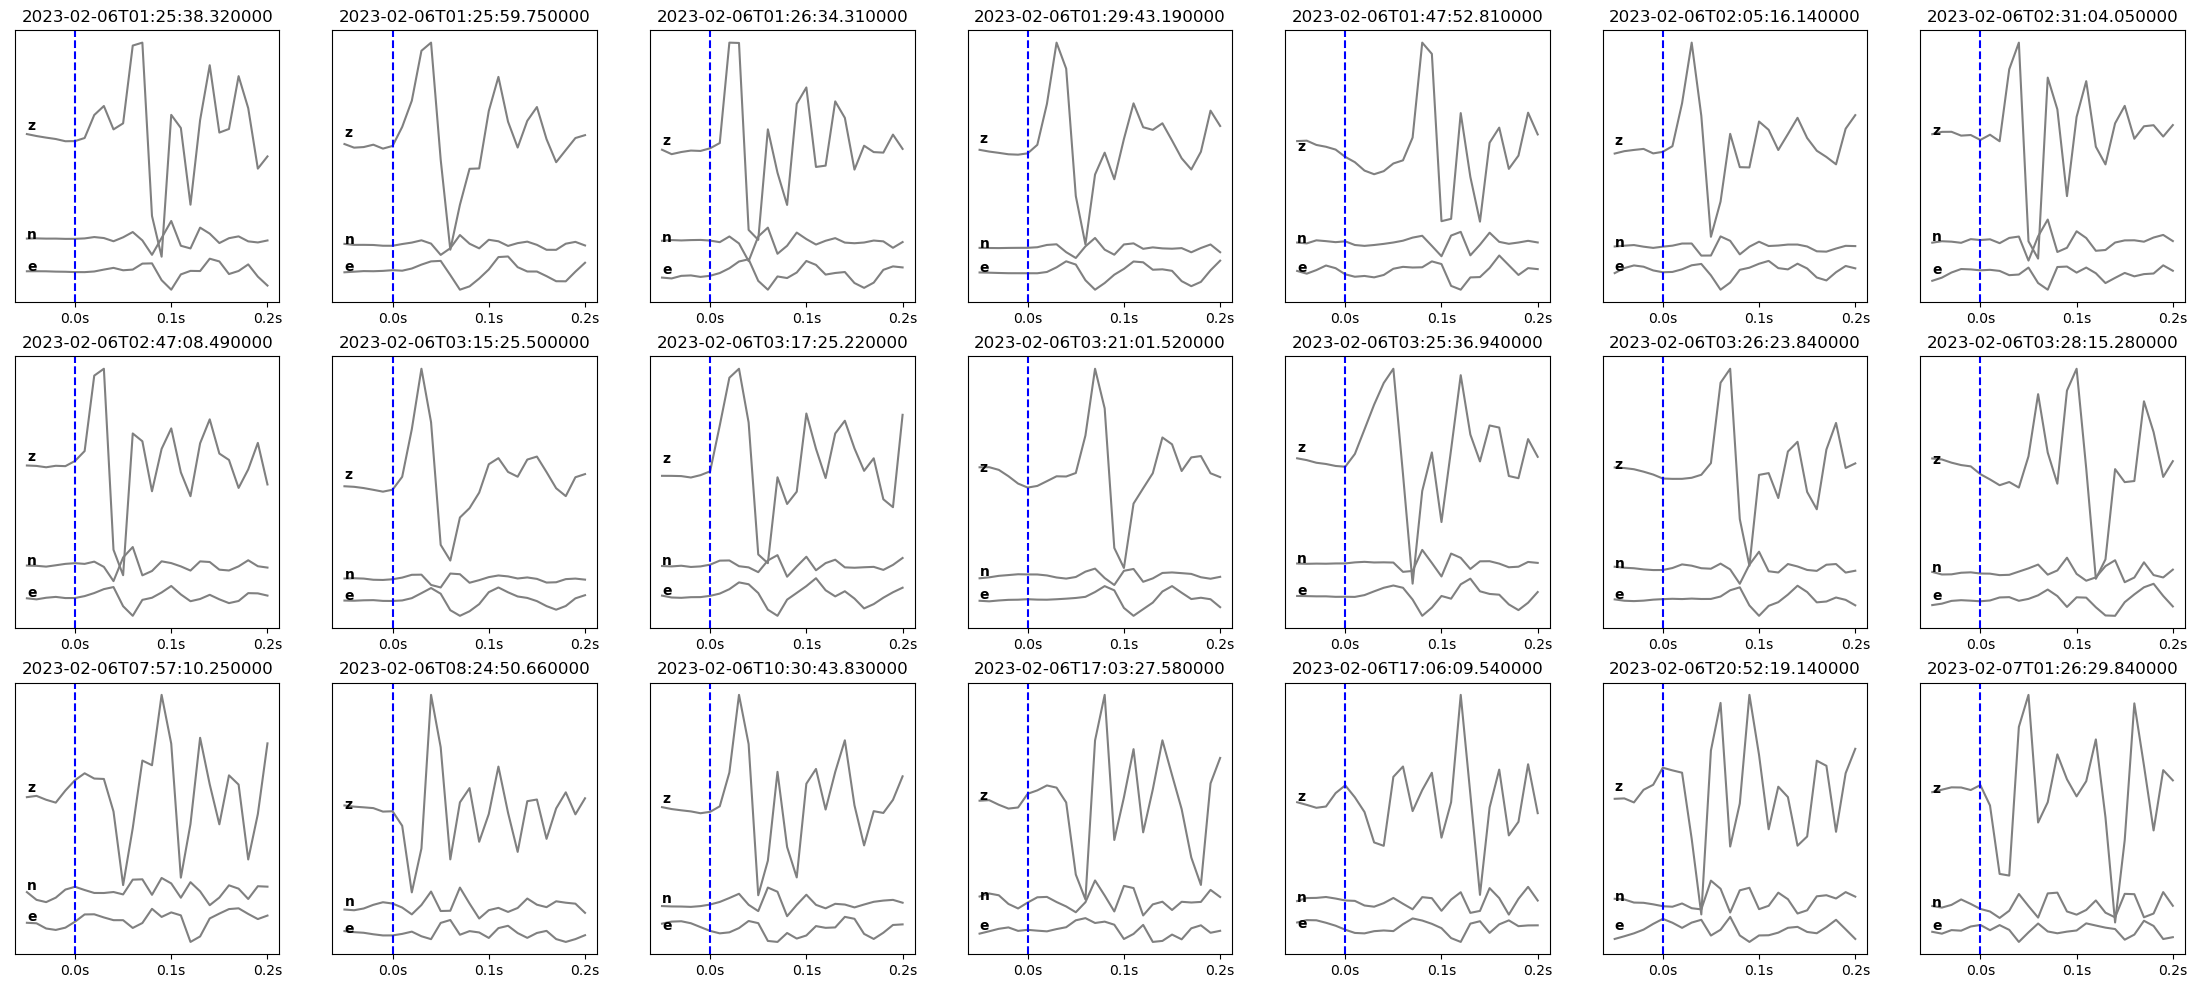

In [59]:
# Plot locatable events (full waveforms and P-waveforms)
for pick_name in data_df_dict.keys():
    csv_filename = f'{pick_name}_good_SNR_and_coherence_location.csv'
    df = pd.read_csv(os.path.join(DATA_DIR, csv_filename), sep=' ')
    p_picks = df['UTC_Time'].values
    sp_times = df['SP_Time'].values

    # extract the waveforms
    good_streams, good_data_flags = \
        extract_waveforms_given_picks(p_picks, sds_client, network=NETWORK,
                                      min_freq=DEF_MIN_FREQ,
                                      station=STATION, channel=CHANNEL,
                                      location=LOCATION, min_snr=MIN_SNR,
                                      cut_left=CUT_LEFT, cut_right=CUT_RIGHT)
    fig_filename = f'{pick_name}_good_SNR_and_coherence_waveforms.png'
    plot_table_of_streams(good_streams, CUT_LEFT, os.path.join(FIG_DIR, fig_filename),
                          xticks=[-1, 0, 1, 2, 3, 4], sp_times=sp_times)

    # extract the P waveforms
    good_P_streams, good_data_flags = \
        extract_waveforms_given_picks(p_picks, sds_client, network=NETWORK,
                                      min_freq=DEF_MIN_FREQ,
                                      station=STATION, channel=CHANNEL,
                                      location=LOCATION, min_snr=MIN_SNR,
                                      cut_left=CUT_LEFT_P, cut_right=CUT_RIGHT_P)

    fig_filename = f'{pick_name}_good_SNR_and_coherence_P_waveforms.png'
    plot_table_of_streams(good_P_streams, CUT_LEFT_P, os.path.join(FIG_DIR, fig_filename),
                              xticks=[0, 0.1, 0.2])


## Make final figures and tables for publication

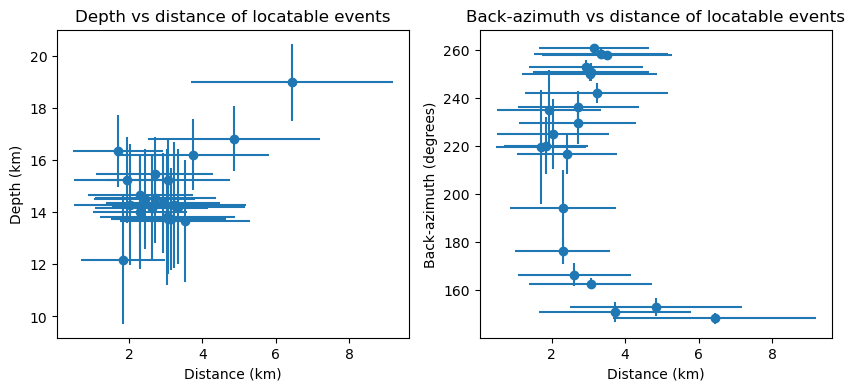

In [62]:
# Plot locatable events (full waveforms and P-waveforms)
for pick_name in data_df_dict.keys():
    csv_filename = f'{pick_name}_good_SNR_and_coherence_location.csv'
    df = pd.read_csv(os.path.join(DATA_DIR, csv_filename), sep=' ')

    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    plt.sca(axes[0])
    plt.errorbar(df['dist_km'], df['depth_km'], xerr=df['dist_unc'], yerr=df['depth_unc'], marker='o', linestyle='none')
    plt.xlabel('Distance (km)')
    plt.ylabel('Depth (km)')
    plt.title('Depth vs distance of locatable events')

    plt.sca(axes[1])
    plt.errorbar(df['dist_km'], df['azimuth'], xerr=df['dist_unc'], yerr=df['az_unc'], marker='o', linestyle='none')
    plt.xlabel('Distance (km)')
    plt.ylabel('Back-azimuth (degrees)')
    plt.title('Back-azimuth vs distance of locatable events')

    fig_filename = f'{pick_name}_good_SNR_and_coherence_cross_section.png'
    plt.savefig(os.path.join(FIG_DIR, fig_filename))


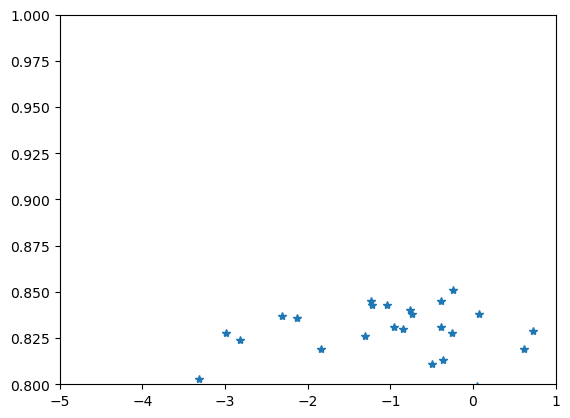

In [34]:
for pick_name in data_df_dict.keys():
    csv_filename = f'{pick_name}_good_SNR_param.csv'
    df = pd.read_csv(os.path.join(DATA_DIR, csv_filename), sep=' ')

    plt.plot(df['coherence'], df['flinn_rect'], '*')
    plt.xlim(-5, 1)
    plt.ylim(0.8, 1)